In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from time import sleep
from os import listdir
import matplotlib.image as mpimg
from matplotlib.animation import FuncAnimation as FA

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

📌 Loading the data:

There are 100 trajectories of engine degradation in EACH of the datasets (train and test).  
For the train data, each engine is run from a certain normal condition till failure.  
For the test data, each engine is NOT run until failure (or we have data until a specific point of the engine's state). The amount of time cycles left for this engine to still be 'normal' is what we call RUL, or Remaining Useful Lifetime.
> **Predicting what the RUL is for the last state of each machine in the test set will be our prediction task.**

In [2]:
folder_path = './CMAPSSData/'

listdir(folder_path)

file_name = 'FD001.txt'

df_train = pd.read_csv(folder_path + 'train_' + file_name, header = None, sep = ' ')
df_test = pd.read_csv(folder_path + 'test_'+file_name, header = None, sep = ' ')
rul_test = pd.read_csv(folder_path + 'RUL_'+file_name, header = None)

for df in [df_train, df_test, rul_test]:
    display(df.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN


,0
0,112
1,98
2,69
3,82
4,91


📌 Attaching column names: We have three operational setting columns (**os + number**), and 21 sensor columns (**s + number**). We have dropped the last two columns containing NaNs.

In [3]:
col_names = []

col_names.append('unit')
col_names.append('time')

for i in range(1,4):
    col_names.append('os'+str(i))
for i in range(1,22):
    col_names.append('s'+str(i))

df_train = df_train.iloc[:,:-2].copy()
df_train.columns = col_names
display(df_train.head())

df_test = df_test.iloc[:,:-2].copy()
df_test.columns = col_names
display(df_test.head())

,unit,time,os1,os2,os3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


,unit,time,os1,os2,os3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


📌 Attaching RUL(remaining useful lifetime) values to the datasets.

For the train data, the RUL values are not specified, but the document regarding this dataset specifies that for the training data, all the engines were run to failure. Thus, for example, if we had five rows for a specific unit, say unit 7:

|unit|time cycle|
|--|--|
|7|1|
|7|2|
|7|3|
|7|4|
|7|5|

Then we know that the last row is when the RUL value becomes 0 (failure), so the RUL for this unit would be attached in this way:

|unit|time cycle|RUL|
|--|--|--|
|7|1|**4**|
|7|2|**3**|
|7|3|**2**|
|7|4|**1**|
|7|5|**0**|

For the test data, we have the 'solutions' for the test engines in a separate file called rul_test (the name that I used for dataframe). I will use that to attach the RUL values for the test as well.

In [4]:
max(df_train['unit'])

100

In [5]:
rul_list = []
engine_numbers = max(df_train['unit'])
for n in np.arange(1,engine_numbers+1):
    
    time_list = np.array(df_train[df_train['unit'] == n]['time'])
    length = len(time_list)
    rul = list(length - time_list)
    rul_list += rul
    
df_train['rul'] = rul_list

rul_list = []

for n in np.arange(1,engine_numbers+1):
    
    time_list = np.array(df_test[df_test['unit'] == n]['time'])
    length = len(time_list)
    rul_val = rul_test.iloc[n-1].item()
    rul = list(length - time_list + rul_val)
    rul_list += rul

df_test['rul'] = rul_list

for df in [df_train, df_test]:
    display(df.head())

,unit,time,os1,os2,os3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


,unit,time,os1,os2,os3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138


Below, we can see an example of all the sensor values of a specific engine in the training set (unit 4), as the engine progresses toward failure.

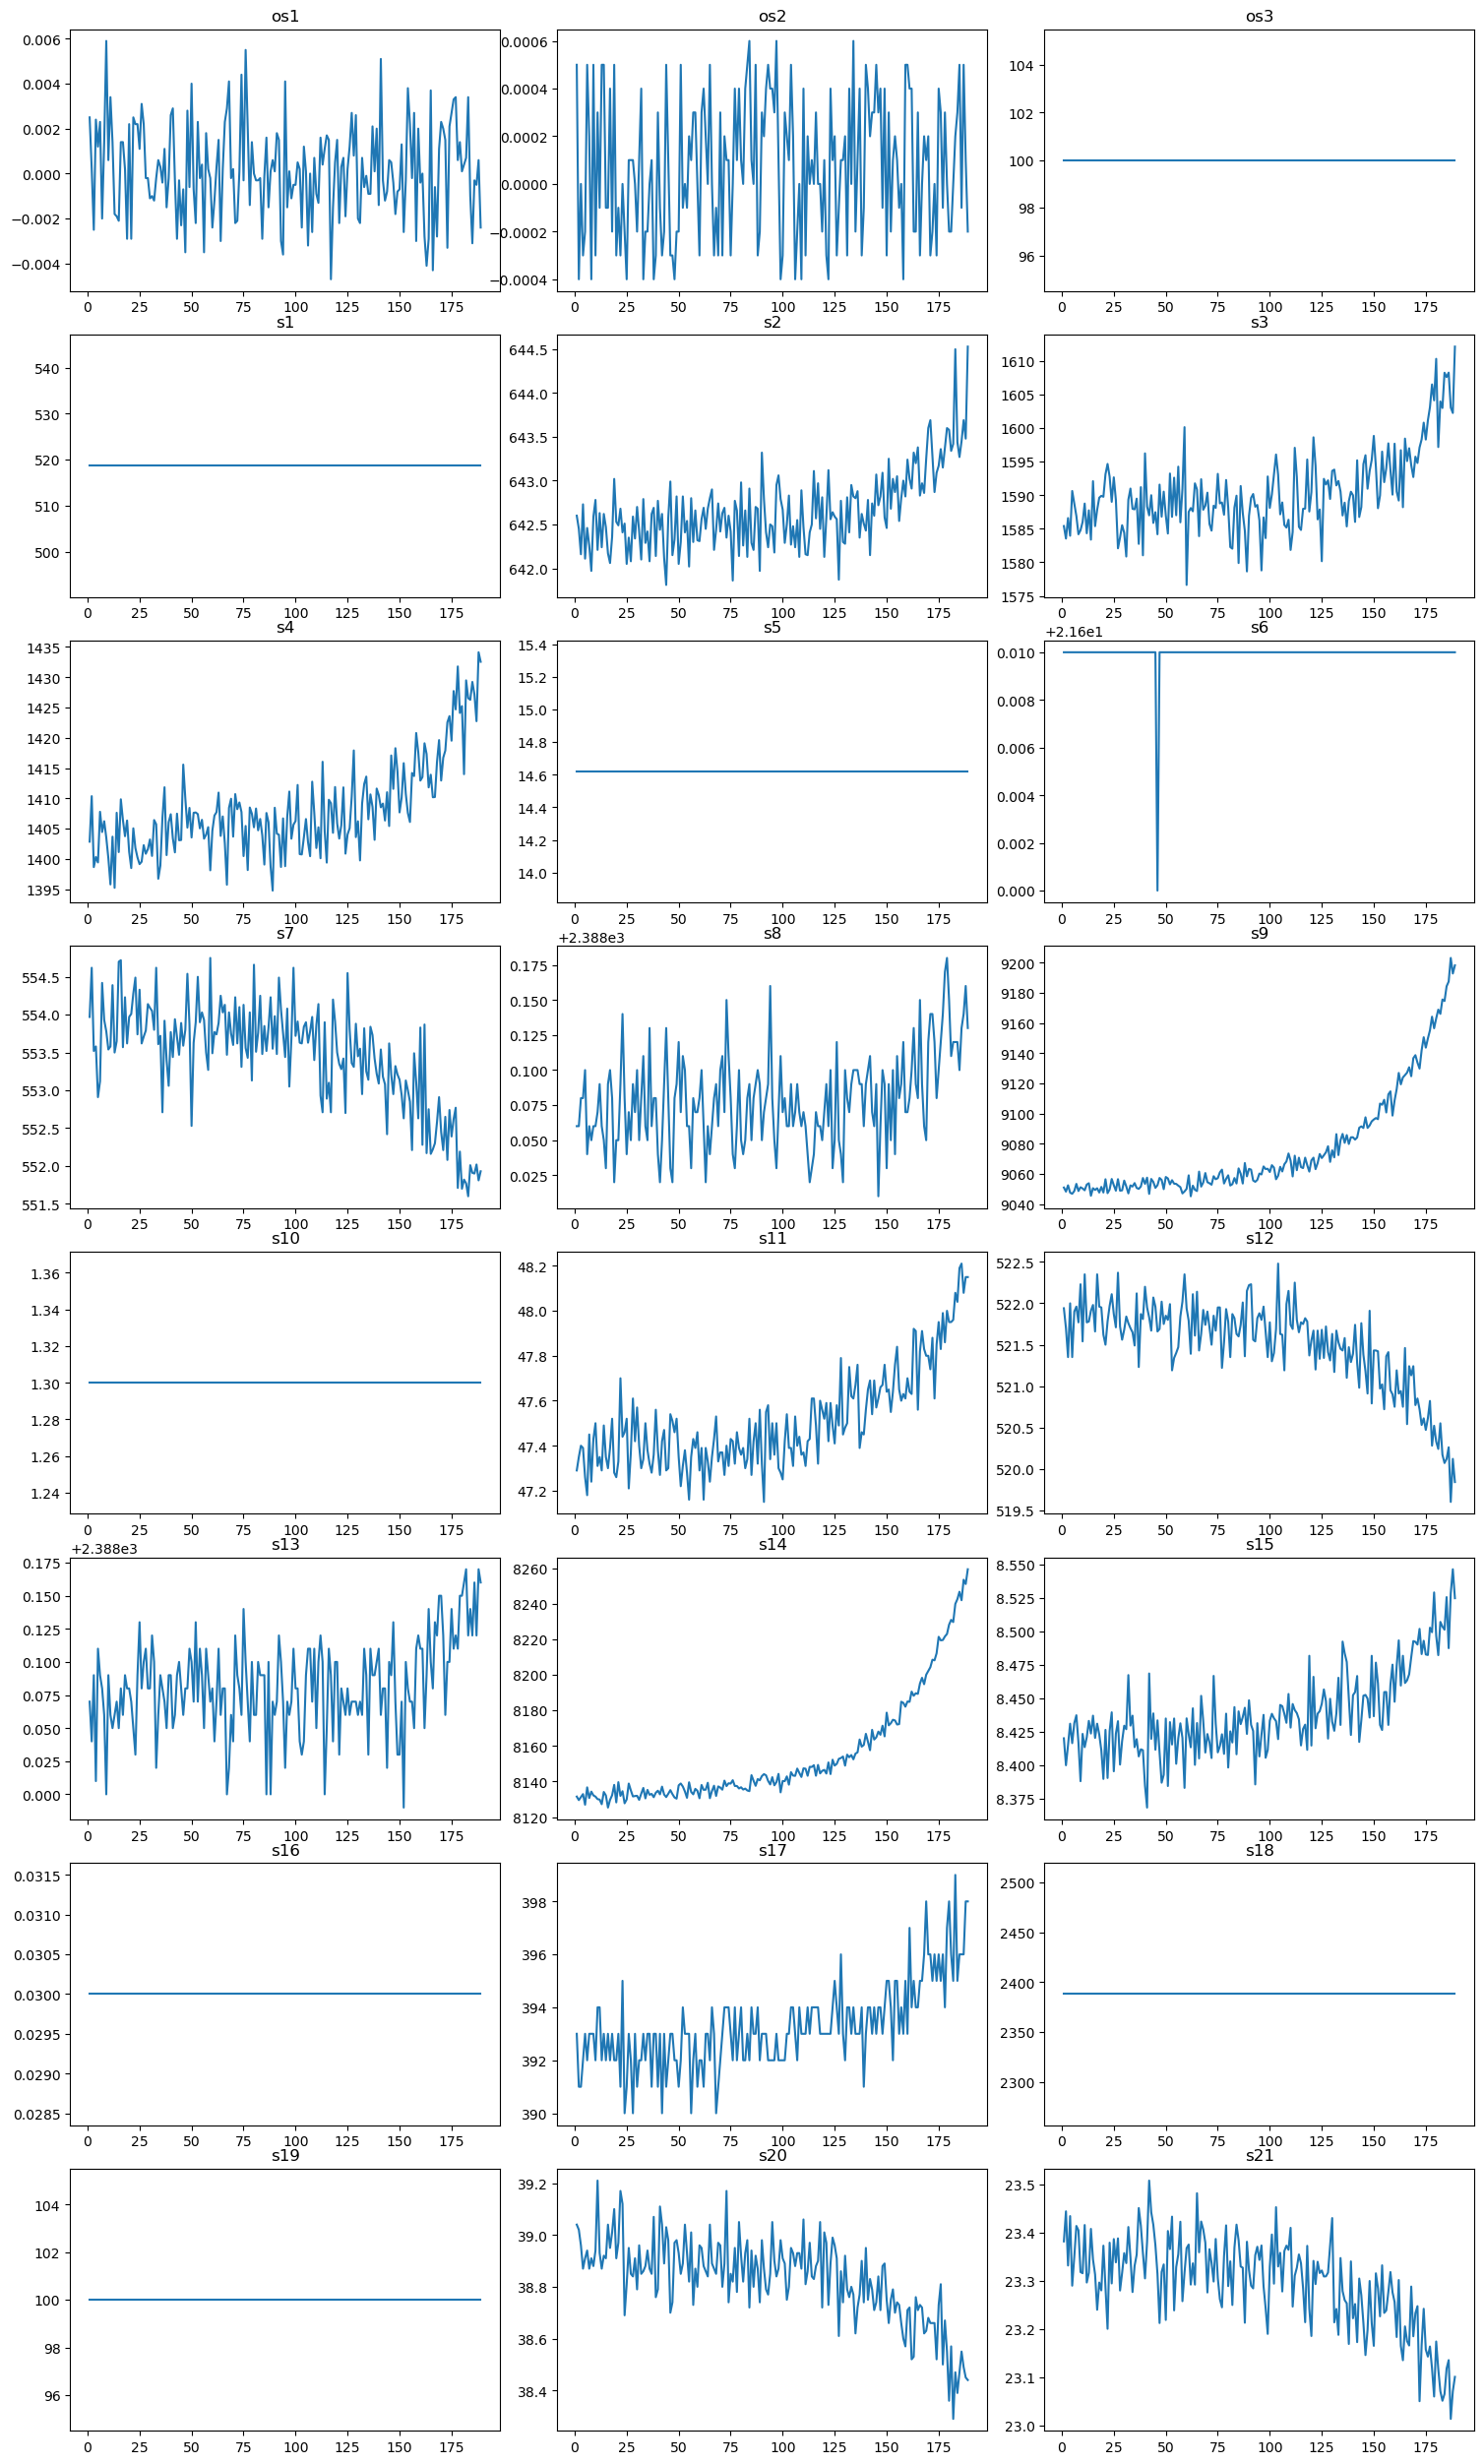

In [6]:
sample = 4
sample_df = df_train[df_train['unit'] == sample].copy()

fig, axes = plt.subplots(8,3, figsize = (15,25))
fig.tight_layout()

j = -1
for c in df_train.columns:
    
    if 's' in c:
        j += 1
        axes[j // 3, j % 3].plot(sample_df['time'], sample_df[c])
        axes[j // 3, j % 3].set_title(c)

We plot the sensor data obtained from sensor 2 for 5 of the engines to show a general trend.


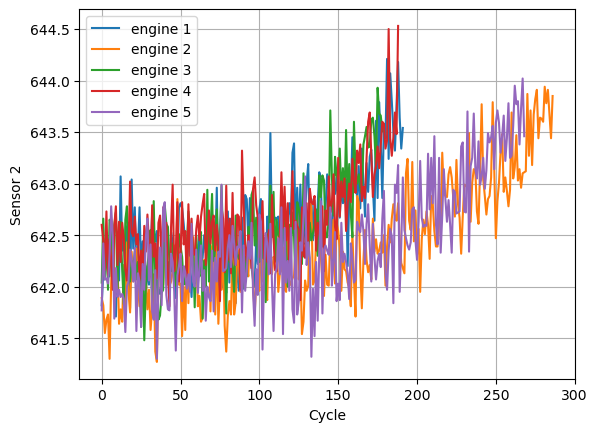

In [7]:
sensor = 's2'
for sample in range(1,6):
    sample_df = df_train[df_train['unit'] == sample].copy()
    sensordata = sample_df[sensor].to_numpy()
    plt.plot(sensordata, label = "engine "+str(sample))
plt.grid()
plt.legend()
plt.ylabel('Sensor 2')
plt.xlabel('Cycle')
plt.show()


We can notice here, that there are multiple sensors which are not changing its value. Perhaps, they are not useful features for prediction. Would they have similar behaviors for other engine units as well? Below show that yes (standard deviation is 0, or practically 0).

In [8]:
df_train[['os3','s1','s5','s6','s10','s16','s18','s19']].describe()

,os3,s1,s5,s6,s10,s16,s18,s19
count,20631.0,2.063100e+04,2.063100e+04,20631.000000,2.063100e+04,2.063100e+04,20631.0,20631.0
mean,100.0,5.186700e+02,1.462000e+01,21.609803,1.300000e+00,3.000000e-02,2388.0,100.0
std,0.0,6.537152e-11,3.394700e-12,0.001389,4.660829e-13,1.556432e-14,0.0,0.0
min,100.0,5.186700e+02,1.462000e+01,21.600000,1.300000e+00,3.000000e-02,2388.0,100.0
25%,100.0,5.186700e+02,1.462000e+01,21.610000,1.300000e+00,3.000000e-02,2388.0,100.0
50%,100.0,5.186700e+02,1.462000e+01,21.610000,1.300000e+00,3.000000e-02,2388.0,100.0
75%,100.0,5.186700e+02,1.462000e+01,21.610000,1.300000e+00,3.000000e-02,2388.0,100.0
max,100.0,5.186700e+02,1.462000e+01,21.610000,1.300000e+00,3.000000e-02,2388.0,100.0


📌 Previously mentioned columns are dropped.

In [9]:
#Drop os3, s1, s5, s6, s10, s16, s18, s19 from both train and test
drop_cols1 = ['os3','s1','s5','s6','s10','s16','s18','s19']

df_train = df_train.drop(drop_cols1, axis = 1)
df_test = df_test.drop(drop_cols1, axis = 1)

for df in [df_train, df_test]:
    display(df.head())

,unit,time,os1,os2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


,unit,time,os1,os2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,141
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,140
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,139
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,138


📌 Sensor values are Min-Max scaled.

$$scaled = \frac{original - min}{max - min}$$

Here, we apply the same max and min values (from the training set) to the test set.

In [10]:
#Minmax Scaling
minmax_dict = {}

for c in df_train.columns:
    if 's' in c:
        minmax_dict[c+'min'] = df_train[c].min()
        minmax_dict[c+'max']=  df_train[c].max()
        
for c in df_train.columns:
    if 's' in c:
        df_train[c] = (df_train[c] - minmax_dict[c+'min']) / (minmax_dict[c+'max'] - minmax_dict[c+'min'])
        
for c in df_test.columns:
    if 's' in c:
        df_test[c] = (df_test[c] - minmax_dict[c+'min']) / (minmax_dict[c+'max'] - minmax_dict[c+'min'])
        
for df in [df_train, df_test]:
    display(df.head())

,unit,time,os1,os2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,191
1,1,2,0.609195,0.250000,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,190
2,1,3,0.252874,0.750000,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,189
3,1,4,0.540230,0.500000,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,188
4,1,5,0.390805,0.333333,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,187


,unit,time,os1,os2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
0,1,1,0.632184,0.750000,0.545181,0.310661,0.269413,0.652174,0.212121,0.127614,0.208333,0.646055,0.220588,0.132160,0.308965,0.333333,0.558140,0.661834,142
1,1,2,0.344828,0.250000,0.150602,0.379551,0.222316,0.805153,0.166667,0.146684,0.386905,0.739872,0.264706,0.204768,0.213159,0.416667,0.682171,0.686827,141
2,1,3,0.517241,0.583333,0.376506,0.346632,0.322248,0.685990,0.227273,0.158081,0.386905,0.699360,0.220588,0.155640,0.458638,0.416667,0.728682,0.721348,140
3,1,4,0.741379,0.500000,0.370482,0.285154,0.408001,0.679549,0.196970,0.105717,0.255952,0.573561,0.250000,0.170090,0.257022,0.250000,0.666667,0.662110,139
4,1,5,0.580460,0.500000,0.391566,0.352082,0.332039,0.694042,0.166667,0.102396,0.273810,0.737740,0.220588,0.152751,0.300885,0.166667,0.658915,0.716377,138


📌 The time series for sensor values were noisy. I'm going to implement what's called the **Exponentially Weighted Average** (learnt from Andrew Ng's Course): If the time-series values are $t_1, t_2, t_3, ..., t_n$, then the smoothed values $v_1, v_2, ..., v_n$ with the parameter $\beta$ follow the following formula:

$$v_0 = 0, v_{t} = \frac{\beta v_{t-1} + (1-\beta) x_{t}}{1-\beta^{t}}$$

In [11]:
#Smoothing Function: Exponentially Weighted Averages

def smooth(s, b = 0.98):

    v = np.zeros(len(s)+1) #v_0 is already 0.
    bc = np.zeros(len(s)+1)

    for i in range(1, len(v)): #v_t = 0.95
        v[i] = (b * v[i-1] + (1-b) * s[i-1]) 
        bc[i] = 1 - b**i

    sm = v[1:] / bc[1:]
    
    return sm

s = [1,2,3,4,5]
print(s)
print(f'After Smoothing: {smooth(s)}')

[1, 2, 3, 4, 5]
After Smoothing: [1.         1.50505051 2.01346756 2.52525046 3.04039827]


In [12]:
#Smoothing each time series for each engine in both training and test sets

for c in df_train.columns:
    
    if 's' in c:
        sm_list = []

        for n in np.arange(1,101):
            s = np.array(df_train[df_train['unit'] == n][c].copy())
            sm = list(smooth(s, 0.98))
            sm_list += sm
        
        df_train[c+'_smoothed'] = sm_list
        
for c in df_test.columns:
    
    if 's' in c:
        sm_list = []

        for n in np.arange(1,101):
            s = np.array(df_test[df_test['unit'] == n][c].copy())
            sm = list(smooth(s, 0.98))
            sm_list += sm
        
        df_test[c+'_smoothed'] = sm_list

Let's take a look at how smoothed values (salmon) look compared to the original series (lightblue), for a particular sensor (unit 10 from train)

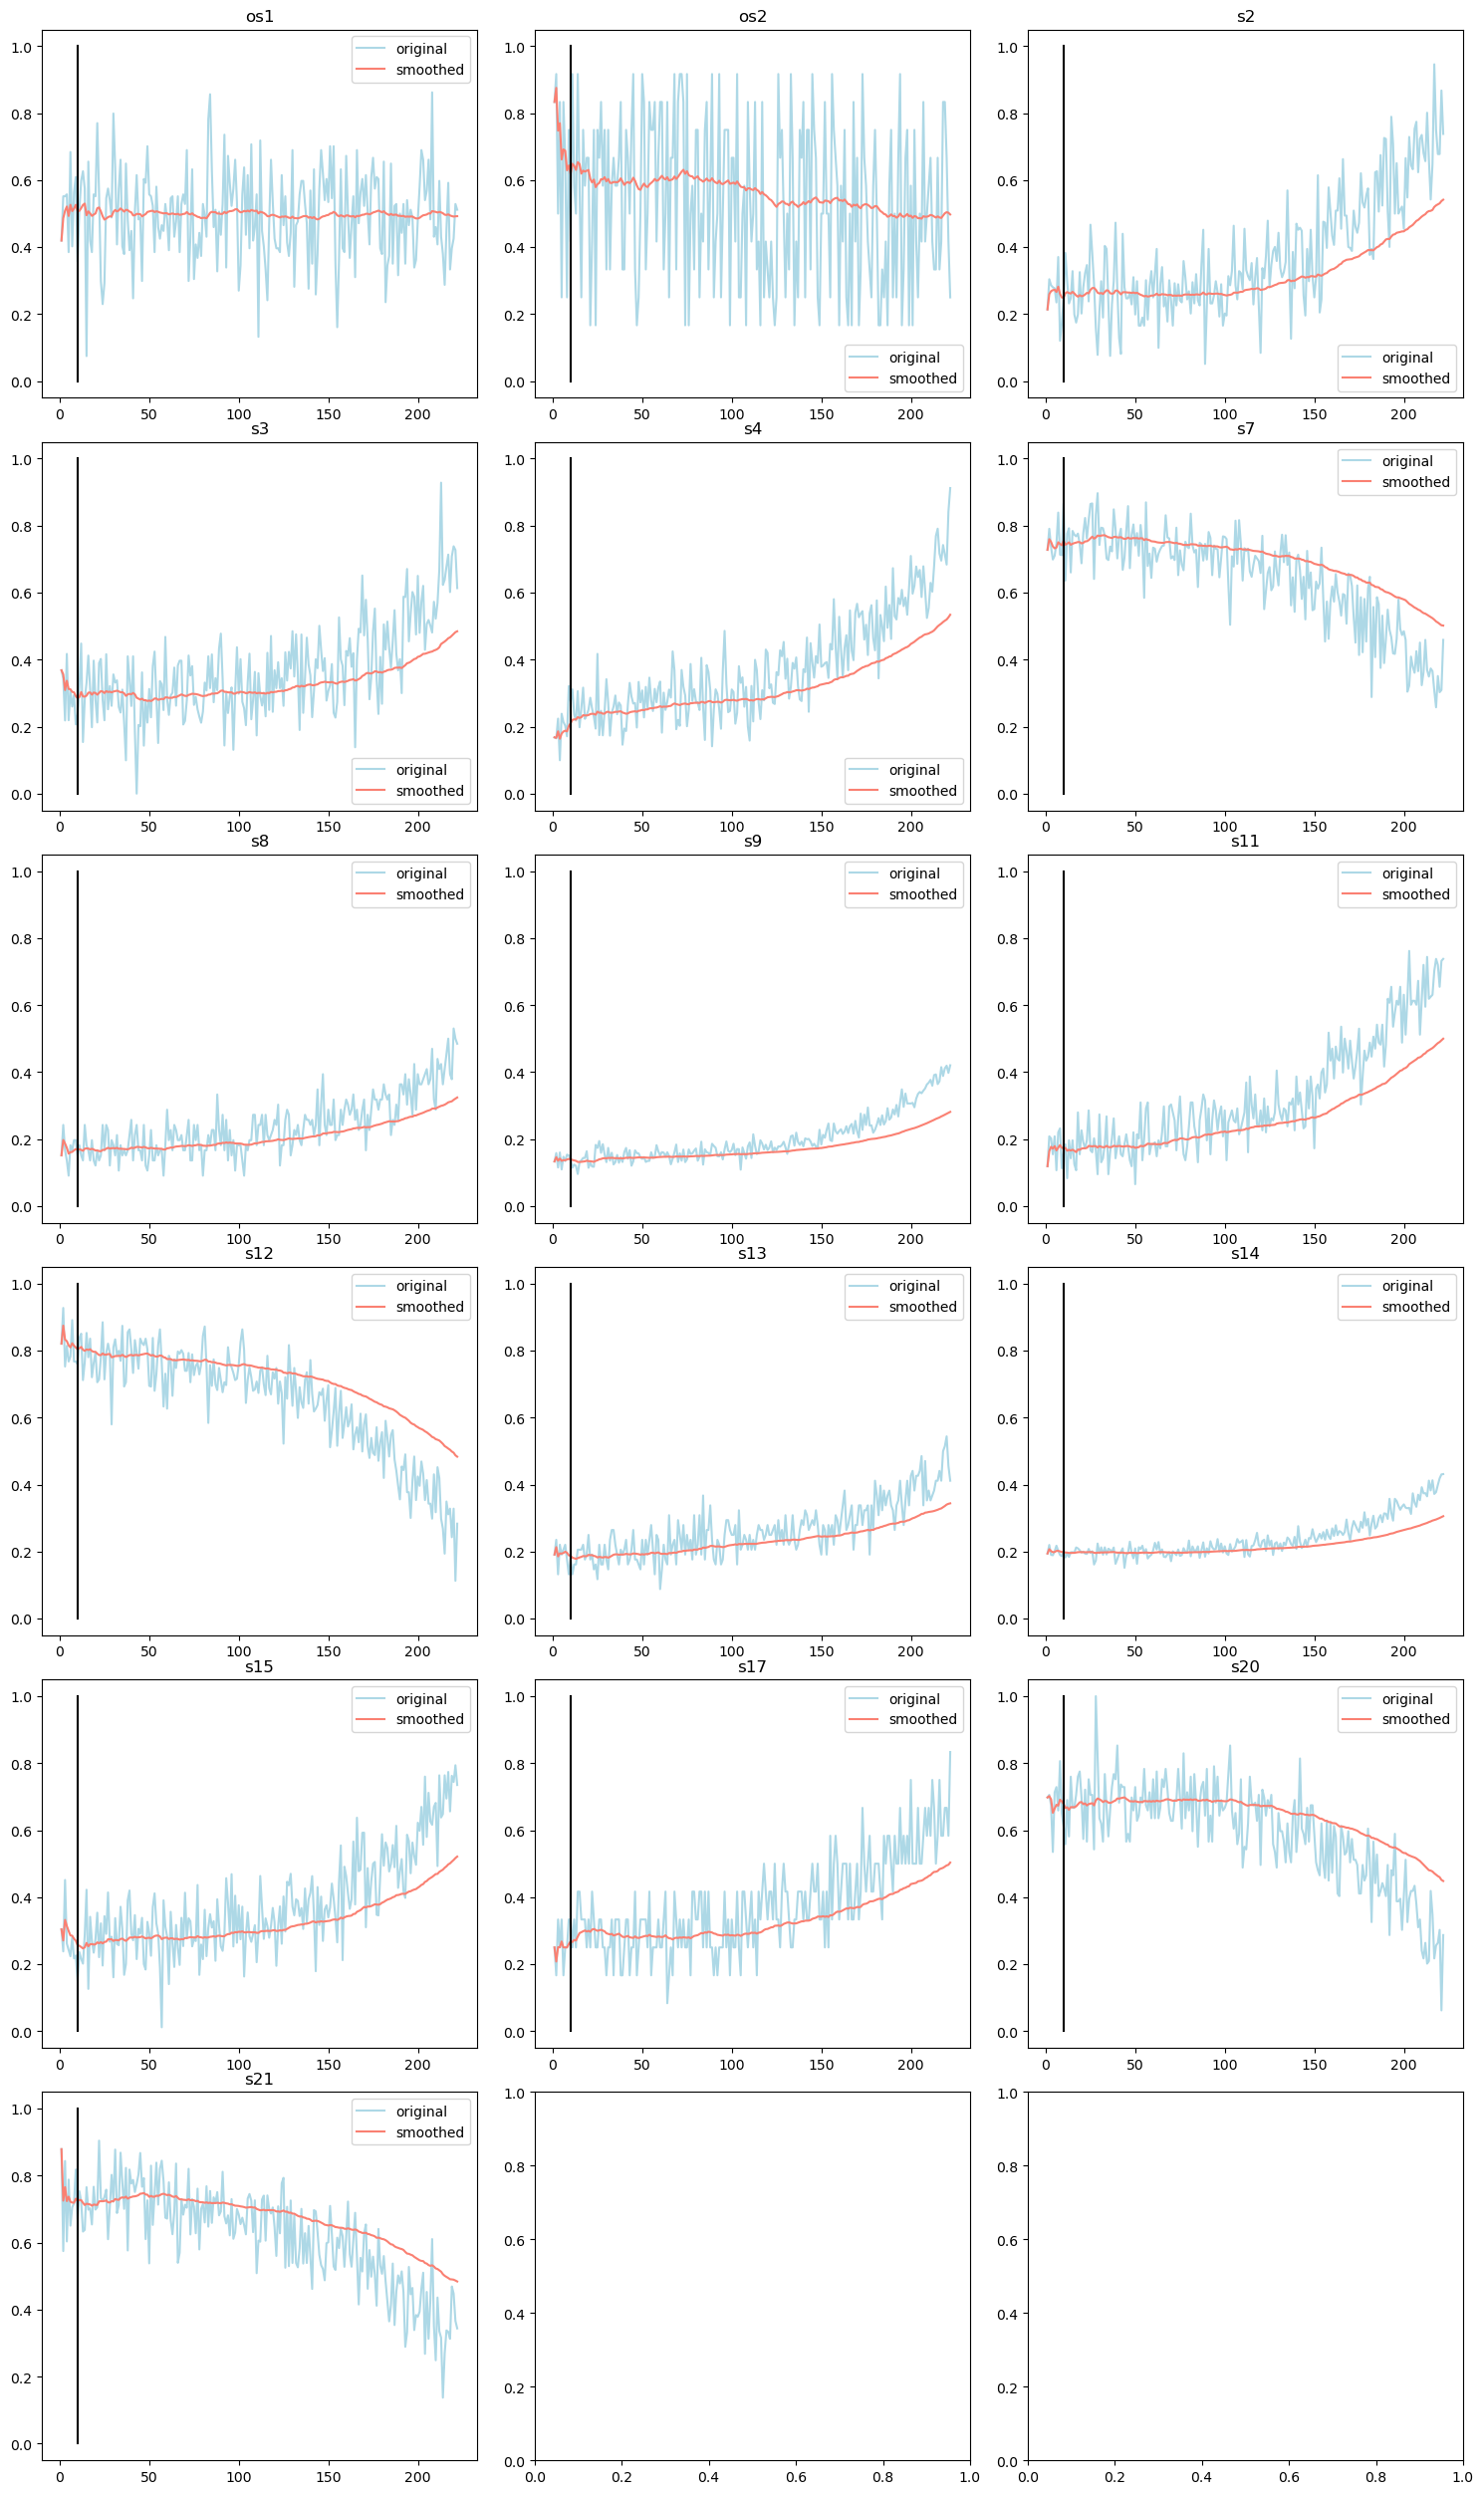

In [13]:
sample = 10
sample_df = df_train[df_train['unit'] == sample].copy()

fig, axes = plt.subplots(6,3, figsize = (15,25))
fig.tight_layout()

j = -1
for c in df_train.columns:
    
    if ('s' in c) and ('smoothed' not in c):
        j += 1
        axes[j // 3, j % 3].plot(sample_df['time'], sample_df[c], c = 'lightblue', label = 'original')
        axes[j // 3, j % 3].plot(sample_df['time'], sample_df[c+'_smoothed'], c = 'salmon', label = 'smoothed')
        axes[j // 3, j % 3].plot([10,10],[0,1], c = 'black')
        axes[j // 3, j % 3].set_title(c)
        axes[j // 3, j % 3].legend()

In [14]:
#Remove the original series

for c in df_train.columns:
    if ('s' in c) and ('smoothed' not in c):
        df_train[c] = df_train[c+'_smoothed']
        df_train.drop(c+'_smoothed', axis = 1, inplace = True)
        
for c in df_test.columns:
    if ('s' in c) and ('smoothed' not in c):
        df_test[c] = df_test[c+'_smoothed']
        df_test.drop(c+'_smoothed', axis = 1, inplace = True)
        
for df in [df_train, df_test]:
    display(df.head())

,unit,time,os1,os2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,191
1,1,2,0.535237,0.208754,0.233936,0.430144,0.331412,0.676638,0.227120,0.104951,0.375060,0.700028,0.243018,0.181025,0.387888,0.333333,0.689688,0.727870,190
2,1,3,0.439208,0.392826,0.271154,0.409527,0.344714,0.688033,0.242630,0.116885,0.332528,0.732432,0.235390,0.177885,0.377535,0.276652,0.668677,0.691652,189
3,1,4,0.465234,0.420437,0.289760,0.370016,0.341231,0.701612,0.262094,0.118852,0.289798,0.772801,0.250520,0.177113,0.323193,0.291254,0.644194,0.684112,188
4,1,5,0.449741,0.402305,0.302174,0.346587,0.354428,0.694673,0.258000,0.125327,0.282753,0.767278,0.247350,0.176618,0.339614,0.317360,0.632735,0.688357,187


,unit,time,os1,os2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
0,1,1,0.632184,0.750000,0.545181,0.310661,0.269413,0.652174,0.212121,0.127614,0.208333,0.646055,0.220588,0.132160,0.308965,0.333333,0.558140,0.661834,142
1,1,2,0.487054,0.497475,0.345899,0.345454,0.245626,0.729436,0.189164,0.137245,0.298521,0.693438,0.242870,0.168831,0.260578,0.375421,0.620781,0.674457,141
2,1,3,0.497321,0.526674,0.356308,0.345854,0.271685,0.714661,0.202125,0.144331,0.328579,0.695452,0.235292,0.164345,0.327936,0.389448,0.657477,0.690404,140
3,1,4,0.560197,0.519802,0.359960,0.330216,0.306804,0.705615,0.200797,0.134383,0.309869,0.664050,0.239081,0.165825,0.309667,0.353523,0.659845,0.683115,139
4,1,5,0.564415,0.515680,0.366539,0.334768,0.312057,0.703206,0.193692,0.127725,0.302363,0.679389,0.235232,0.163103,0.307839,0.314626,0.659651,0.690038,138


📌 When we look at the length of the trajectories for each unit in both the training and test sets, thus 200 engines, we see that for the training set that had the entire trajectories, have minimum length of 128. However, for the test set, we have a minimum value of 31. This means that if we were to predict the final RUL for every test engine unit, we cannot use a window size greater than 31 for training the model. Furthermore, if you take a look at the smoothed series visualization, I put a **black** vertical line for every graph, at about time step 10. This is because, when we smooth using exponentially weighted averages, seems like in the beginning, the smoothing process is sort of 'warming up'? So it seems a little shaky. Thus, I will be taking that part out of the training process. This will happen for test data as well. Thus, the maximum window size we can take is 31 - 10 = 21. I will go with **20**.

In [15]:
print('training set time cycles:')
display(df_train.groupby('unit')['time'].max().describe())
print('test set time cycles:')
display(df_test.groupby('unit')['time'].max().describe())

training set time cycles:


count    100.000000
mean     206.310000
std       46.342749
min      128.000000
25%      177.000000
50%      199.000000
75%      229.250000
max      362.000000
Name: time, dtype: float64

test set time cycles:


count    100.000000
mean     130.960000
std       53.593479
min       31.000000
25%       88.750000
50%      133.500000
75%      164.250000
max      303.000000
Name: time, dtype: float64

In [16]:
n_features = len([c for c in df_train.columns if 's' in c]) #plus one for time
window = 1
print(f'number of features: {n_features}, window size: {window}')

number of features: 16, window size: 1


📌 Splitting **Train and Validation** Sets: Out of the 100 engines in the training set, I will randomly take out 20 engines for validation.

In [17]:
np.random.seed(5)
units = np.arange(1,101)
train_units = list(np.random.choice(units, 80, replace = False))
val_units = list(set(units) - set(train_units))
print(val_units)

[8, 9, 16, 17, 28, 31, 45, 54, 62, 63, 66, 74, 76, 77, 78, 79, 81, 91, 93, 100]


📌 Prepare Training, Validation and Test Dataloaders.

For training process, I will take batches of 64.  
For the validation process, I will take the entire validation set (all the windows avaiable).
For the test process, I will take the LAST window of each engine's given trajectory, thus it will have exactly 100 X(size 20 window)s and 100 y(RUL)s.

In [18]:
train_data = df_train[df_train['unit'].isin(train_units)].copy()
val_data = df_train[df_train['unit'].isin(val_units)].copy()

train_indices = list(train_data[(train_data['rul'] >= (window - 1)) & (train_data['time'] > 10)].index)
val_indices = list(val_data[(val_data['rul'] >= (window - 1)) & (val_data['time'] > 10)].index)

In [19]:
list(train_data[(train_data['rul'] >= (window - 1)) & (train_data['time'] > 10)].index)

[10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191

In [44]:
class data(Dataset):
    
    def __init__(self, list_indices, df_train):
        
        self.indices = list_indices
        self.df_train = df_train
        
    def __len__(self):
        
        return len(self.indices)
    
    def __getitem__(self, idx):
        
        ind = self.indices[idx]
        X_ = self.df_train.iloc[ind, :].drop(['time','unit','rul']).copy().to_numpy()
        y_ = self.df_train.iloc[ind]['rul']
        
        return X_, y_
    
torch.manual_seed(5)
    
train = data(train_indices, df_train)
val = data(val_indices, df_train)

trainloader = DataLoader(train, batch_size = 64, shuffle = True)
valloader = DataLoader(val, batch_size = len(val_indices), shuffle = True)

units = np.arange(1,101)

class test(Dataset):
    
    def __init__(self, units, df_test):
        
        self.units = units
        self.df_test = df_test
        
    def __len__(self):
        
        return len(self.units)
    
    def __getitem__(self, idx):
        
        n = self.units[idx]
        U = self.df_test[self.df_test['unit'] == n].copy()
        X_ = U.reset_index().iloc[-1:].drop(['time','index','unit','rul'], axis = 1).copy().to_numpy()
        y_ = U['rul'].min()
        
        return X_, y_
    
test = test(units, df_test)
testloader = DataLoader(test, batch_size = 100)

In [21]:
dataiter = iter(trainloader)
x,y = next(dataiter)


## 2. Model Building and Training ##

📌 I will be using a LSTM Model, with some linear - relu layers before the final output.

In [22]:
## Custom loss function
class CustomLoss(nn.Module):
    def __init__(self, alpha):
        super(CustomLoss, self).__init__()
        self.alpha = alpha

    def forward(self, predictions, targets):
        return (1-self.alpha)*torch.mean((predictions - targets) ** 2) + self.alpha*(torch.mean(torch.relu(predictions-targets)))

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cuda'
# device = 'cpu'


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(16, 100)
        self.linear2 = nn.Linear(100,100)
        self.output = nn.Linear(100,1)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        out = self.relu(self.output(x))
        return out
    
learning_rate = 0.001
n_hidden_units = 12

torch.manual_seed(15)
num_input = 16
model = MLP().to(device)
loss_fn = nn.MSELoss()
# loss_fn = CustomLoss(0)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                             
ks = [key for key in model.state_dict().keys() if 'linear' in key and '.weight' in key]

for k in ks:
    nn.init.kaiming_uniform_(model.state_dict()[k])
    
bs = [key for key in model.state_dict().keys() if 'linear' in key and '.bias' in key]

for b in bs:
    nn.init.constant_(model.state_dict()[b], 0)

📌 Validation and Test Functions

In [53]:
def validation():
    
    model.eval()
    X, y = next(iter(valloader))
    X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)
    
    with torch.no_grad():
        y_pred = model(X)
        
        val_loss = loss_fn(y_pred, y).item()
        
    return val_loss

loss_L1 = nn.L1Loss()
    
def test():
    model.eval()
    X, y = next(iter(testloader))
    X, y = X.to(device).to(torch.float32).squeeze(), y.to(device).to(torch.float32).unsqueeze(1)
    
    with torch.no_grad():
        y_pred = model(X)
        y_pred = torch.round(y_pred)
        test_loss_MSE = loss_fn(y_pred, y).item()
        test_loss_L1 = loss_L1(y_pred, y).item()
        
    return test_loss_MSE, test_loss_L1,  y_pred, y

📌 I have commented out a section below, which is to see if the model can overfit a minibatch. I think this process is done to see if the model has enough capacity to fit at least something, or to find a bug in the implementation before going full on training.

📌 Training Loop: I have trained using Adam Optimizer for 100 epochs with learning rate = 0.001

In [25]:
T = []
V = []
epochs = 35
alpha = 0
for i in tqdm(range(epochs)):
    
    L = 0
    model.train()
    
    for batch, (X,y) in enumerate(trainloader):
        
        X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32).unsqueeze(1)
        
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        L += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # alpha = alpha*(1 +((y<y_pred).count_nonzero().item()/len(y)+0.5))
        # loss_fn = CustomLoss(alpha)
        # print(alpha)
    val_loss = validation()
    
    T.append(L/len(trainloader))
    V.append(val_loss)
    (y<y_pred).count_nonzero().item()/len(y)
    # if (i+1) % 10 == 0:
    #     sleep(0.5)
    print(f'epoch:{i+1}, avg_train_loss:{L/len(trainloader)}, val_loss:{val_loss}')
    


  0%|          | 0/35 [00:00<?, ?it/s]

  3%|▎         | 1/35 [00:26<15:06, 26.66s/it]

epoch:1, avg_train_loss:7630.244827944591, val_loss:3149.182373046875


  6%|▌         | 2/35 [00:48<13:03, 23.75s/it]

epoch:2, avg_train_loss:3399.710468828439, val_loss:2391.85107421875


  9%|▊         | 3/35 [01:09<12:04, 22.65s/it]

epoch:3, avg_train_loss:2724.2297490744227, val_loss:2136.7099609375


 11%|█▏        | 4/35 [01:31<11:27, 22.19s/it]

epoch:4, avg_train_loss:2585.083001439351, val_loss:2021.401611328125


 14%|█▍        | 5/35 [01:52<10:57, 21.93s/it]

epoch:5, avg_train_loss:2497.7562451956264, val_loss:1994.6094970703125


 17%|█▋        | 6/35 [02:14<10:39, 22.04s/it]

epoch:6, avg_train_loss:2451.631862900822, val_loss:1957.8389892578125


 20%|██        | 7/35 [02:37<10:20, 22.17s/it]

epoch:7, avg_train_loss:2430.0139346448295, val_loss:1884.9923095703125


 23%|██▎       | 8/35 [02:59<09:54, 22.03s/it]

epoch:8, avg_train_loss:2416.5539673341805, val_loss:1850.2540283203125


 26%|██▌       | 9/35 [03:16<08:54, 20.57s/it]

epoch:9, avg_train_loss:2409.2301187170556, val_loss:1796.4461669921875


 29%|██▊       | 10/35 [03:38<08:44, 20.97s/it]

epoch:10, avg_train_loss:2408.0418652147655, val_loss:1795.7557373046875


 31%|███▏      | 11/35 [04:00<08:35, 21.48s/it]

epoch:11, avg_train_loss:2404.676164619415, val_loss:1803.271728515625


 34%|███▍      | 12/35 [04:22<08:15, 21.53s/it]

epoch:12, avg_train_loss:2399.9871179052147, val_loss:1797.302734375


 37%|███▋      | 13/35 [04:44<07:55, 21.61s/it]

epoch:13, avg_train_loss:2399.0566009153804, val_loss:2012.456787109375


 40%|████      | 14/35 [05:05<07:30, 21.44s/it]

epoch:14, avg_train_loss:2396.4312278410516, val_loss:1792.399169921875


 43%|████▎     | 15/35 [05:26<07:09, 21.45s/it]

epoch:15, avg_train_loss:2390.682375007844, val_loss:1784.5015869140625


 46%|████▌     | 16/35 [05:48<06:50, 21.60s/it]

epoch:16, avg_train_loss:2391.15219128467, val_loss:1792.49462890625


 49%|████▊     | 17/35 [06:10<06:27, 21.54s/it]

epoch:17, avg_train_loss:2387.9580911536773, val_loss:1816.3040771484375


 51%|█████▏    | 18/35 [06:30<06:01, 21.27s/it]

epoch:18, avg_train_loss:2387.722310629236, val_loss:1920.15673828125


 54%|█████▍    | 19/35 [06:51<05:38, 21.13s/it]

epoch:19, avg_train_loss:2383.9391741771774, val_loss:1790.388427734375


 57%|█████▋    | 20/35 [07:10<05:07, 20.53s/it]

epoch:20, avg_train_loss:2376.94448399065, val_loss:1865.4266357421875


 60%|██████    | 21/35 [07:30<04:43, 20.28s/it]

epoch:21, avg_train_loss:2376.9324436417546, val_loss:1788.6641845703125


 63%|██████▎   | 22/35 [07:51<04:27, 20.60s/it]

epoch:22, avg_train_loss:2377.1085915929343, val_loss:1824.7357177734375


 66%|██████▌   | 23/35 [08:13<04:11, 20.97s/it]

epoch:23, avg_train_loss:2374.2446171404367, val_loss:1797.1715087890625


 69%|██████▊   | 24/35 [08:35<03:53, 21.21s/it]

epoch:24, avg_train_loss:2370.271518201713, val_loss:1824.85986328125


 71%|███████▏  | 25/35 [08:56<03:32, 21.25s/it]

epoch:25, avg_train_loss:2366.5961384600905, val_loss:1792.722900390625


 74%|███████▍  | 26/35 [09:18<03:11, 21.26s/it]

epoch:26, avg_train_loss:2373.0346424761547, val_loss:1832.6114501953125


 77%|███████▋  | 27/35 [09:39<02:50, 21.29s/it]

epoch:27, avg_train_loss:2362.802731923789, val_loss:1797.41357421875


 80%|████████  | 28/35 [10:00<02:29, 21.36s/it]

epoch:28, avg_train_loss:2356.8721967949923, val_loss:1790.02197265625


 83%|████████▎ | 29/35 [10:22<02:08, 21.36s/it]

epoch:29, avg_train_loss:2362.333668168769, val_loss:1787.6676025390625


 86%|████████▌ | 30/35 [10:43<01:46, 21.21s/it]

epoch:30, avg_train_loss:2351.451456705729, val_loss:1785.3592529296875


 89%|████████▊ | 31/35 [11:03<01:24, 21.03s/it]

epoch:31, avg_train_loss:2350.7169272794304, val_loss:1823.65869140625


 91%|█████████▏| 32/35 [11:24<01:02, 20.95s/it]

epoch:32, avg_train_loss:2349.4613723448483, val_loss:1846.902099609375


 94%|█████████▍| 33/35 [11:45<00:41, 20.89s/it]

epoch:33, avg_train_loss:2349.3309885048006, val_loss:1837.6141357421875


 97%|█████████▋| 34/35 [12:06<00:21, 21.09s/it]

epoch:34, avg_train_loss:2348.9848343569593, val_loss:1795.357177734375


100%|██████████| 35/35 [12:27<00:00, 21.36s/it]

epoch:35, avg_train_loss:2340.7222537611383, val_loss:1853.5142822265625


<function matplotlib.pyplot.show(close=None, block=None)>

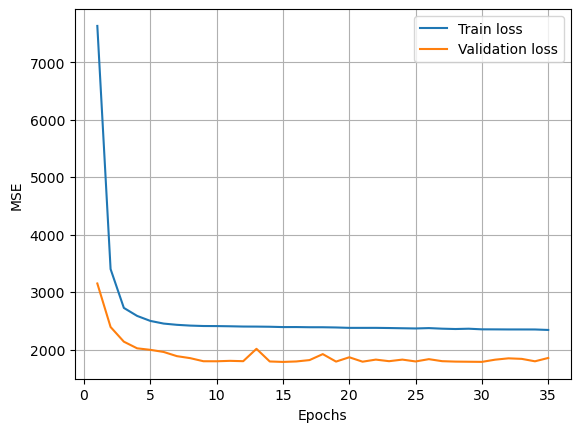

In [29]:
plt.plot(np.arange(1,len(T)+1), T, label= 'Train loss')
plt.plot(np.arange(1,len(V)+1), V, label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show

In [30]:
fig, ax = plt.subplots(figsize = (12,8))

def animate(i):
    ax.clear()
    line1, = ax.plot(np.arange(1,i+1), T[:i], label = 'train_loss')
    line2, = ax.plot(np.arange(1,i+1), V[:i], label = 'val_loss')
    ax.legend()
    ax.grid(True)
    ax.set_xlim(0,101)
    ax.set_ylim(0,4000)
    ax.set_xlabel('epochs')
    ax.set_ylabel('MSE')
                     
    return line1, line2
                     
    
animation = FA(fig, animate, np.arange(1,len(T)+1), interval = 50)

%time animation.save('animation3.gif', writer='imagemagick', fps=20)

plt.close(fig)

MovieWriter imagemagick unavailable; using Pillow instead.


CPU times: total: 2.53 s
Wall time: 4.1 s


## 3. Prediction on Test Set ##

In [38]:
df_test[-1:]

,unit,time,os1,os2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
13095,100,198,0.489382,0.553531,0.431213,0.428165,0.440263,0.614365,0.209399,0.349843,0.372809,0.645313,0.231993,0.389547,0.427165,0.427404,0.548475,0.581365,20


In [54]:
mse, l1, y_pred, y = test()

print(f'Test MSE:{round(mse,2)}, L1:{round(l1,2)}')

Test MSE:1744.99, L1:32.51


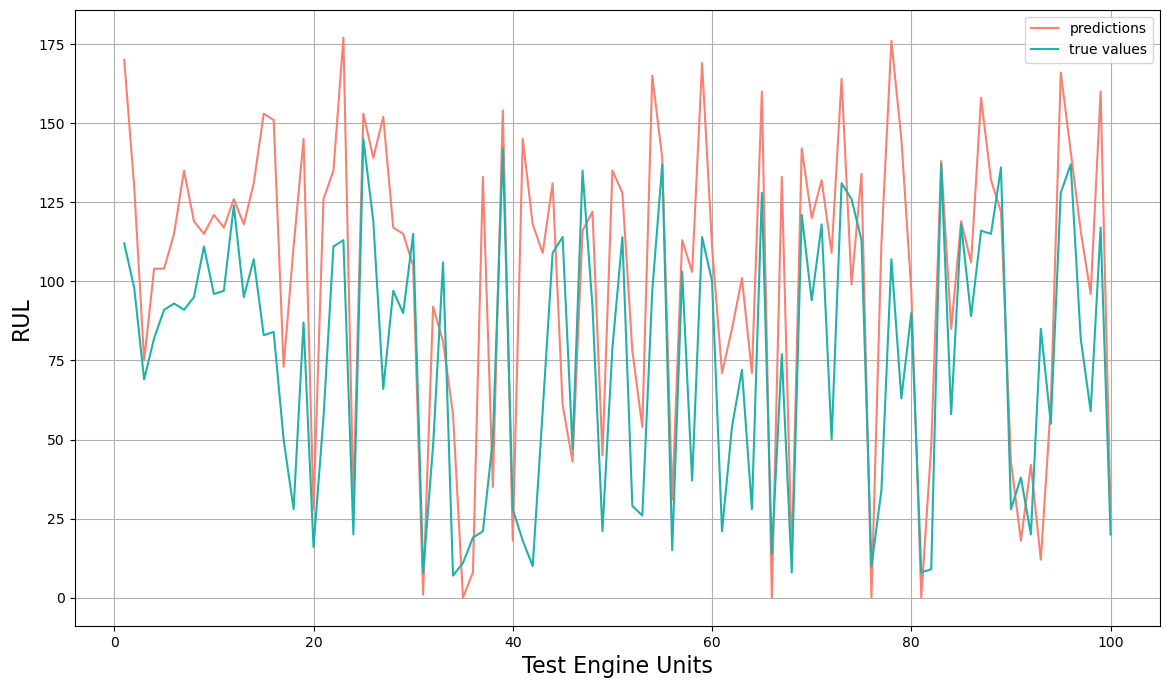

In [55]:
fig, ax = plt.subplots(figsize = (14,8))
ax.plot(np.arange(1,101), y_pred.cpu().numpy(), label = 'predictions', c = 'salmon')
ax.plot(np.arange(1,101), y.cpu().numpy(), label = 'true values', c = 'lightseagreen')
ax.set_xlabel('Test Engine Units', fontsize = 16)
ax.set_ylabel('RUL', fontsize = 16)
ax.grid(True)
ax.legend()
plt.show()

In [60]:
y_pred = y_pred.squeeze()
y = y.squeeze()

tensor([112.,  98.,  69.,  82.,  91.,  93.,  91.,  95., 111.,  96.,  97., 124.,
         95., 107.,  83.,  84.,  50.,  28.,  87.,  16.,  57., 111., 113.,  20.,
        145., 119.,  66.,  97.,  90., 115.,   8.,  48., 106.,   7.,  11.,  19.,
         21.,  50., 142.,  28.,  18.,  10.,  59., 109., 114.,  47., 135.,  92.,
         21.,  79., 114.,  29.,  26.,  97., 137.,  15., 103.,  37., 114., 100.,
         21.,  54.,  72.,  28., 128.,  14.,  77.,   8., 121.,  94., 118.,  50.,
        131., 126., 113.,  10.,  34., 107.,  63.,  90.,   8.,   9., 137.,  58.,
        118.,  89., 116., 115., 136.,  28.,  38.,  20.,  85.,  55., 128., 137.,
         82.,  59., 117.,  20.], device='cuda:0')
tensor([170., 130.,  75., 104., 104., 115., 135., 119., 115., 121., 117., 126.,
        118., 131., 153., 151.,  73., 111., 145.,  28., 126., 135., 177.,  31.,
        153., 139., 152., 117., 115., 105.,   1.,  92.,  81.,  58.,   0.,   8.,
        133.,  35., 154.,  18., 145., 118., 109., 131.,  61.,  43., 11

In [70]:
(y_pred<y).count_nonzero().item()

17

In [72]:
torch.dot(y - y_pred, 1.0*(y_pred<y)).item()/(y_pred<y).count_nonzero().item()

19.470588235294116

In [62]:
torch.sum(torch.abs(y-y_pred)).item()/len(y)

32.51

In [64]:
torch.save(model.state_dict(), 'saved_models\\MLP')